## Importing required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, MaxPooling1D, Embedding, Dropout, Input, BatchNormalization, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 134kB/s 
     |████████████████████████████████| 983kB 41.9MB/s 
     |████████████████████████████████| 266kB 48.6MB/s 
     |████████████████████████████████| 1.3MB 42.1MB/s 
     |████████████████████████████████| 471kB 38.9MB/s 
     |████████████████████████████████| 890kB 38.7MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 
     |████████████████████████████████| 2.9MB 42.1MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.0-cp36-none-any.whl size=25274500 sha256=99e1001942b21703ddf64255990eb6e94d8d3d05601a52ce9f5ef54e793e3816
  Stored in directory: /root/.cache/pip/wheels/5c/73/05/f36d0027bb6575384e21506dbba8db36a7825f15a24f09b2d5
  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=dd5ae5a84d300405baab58b449eaefa38090278d4e822c072d6046e89dd241b9
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for lan

In [ ]:
import ktrain
from ktrain import text

## Reading data and train-test split:

In [ ]:
data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/nlp_scripts/MIMIC-III/Prepared_Data_DL.pkl')

In [ ]:
data.shape

(51113, 12)

Shuffling samples

In [ ]:
data2 = data.sample(n = len(data), random_state = 42)

In [ ]:
data2 = data2.reset_index(drop = True)

In [ ]:
data2.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,CATEGORY,TEXT,OUTPUT_LABEL
0,21284,126923,2168-05-03 07:15:00,2168-05-10 14:50:00,NaT,ELECTIVE,2171-02-04 04:04:00,EMERGENCY,999.551389,Discharge summary,Admission Date: [**2168-5-3**] Discharg...,0
1,9344,116730,2199-05-21 02:59:00,2199-06-26 14:32:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2199-5-21**] ...,0
2,4308,109424,2141-04-04 18:38:00,2141-04-06 16:52:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2141-4-4**] D...,0
3,82935,157739,2183-01-17 20:44:00,2183-01-19 11:19:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2183-1-17**] ...,0
4,27266,165453,2197-10-17 15:27:00,2197-10-26 12:00:00,NaT,EMERGENCY,2197-11-24 19:46:00,EMERGENCY,29.323611,Discharge summary,Admission Date: [**2197-10-17**] ...,1


Save 20% of the data for validation:

In [ ]:
df_valid = data2.sample(frac=0.2,random_state=42)

In [ ]:
df_valid.shape

(10223, 12)

In [ ]:
df_valid['OUTPUT_LABEL'].value_counts()

0    9611
1     612
Name: OUTPUT_LABEL, dtype: int64

In [ ]:
df_valid.to_pickle('/content/drive/MyDrive/Colab Notebooks/nlp_scripts/MIMIC-III/df_valid.pkl')

In [ ]:
df_train_all = data2.drop(df_valid.index)

In [ ]:
df_train_all.shape

(40890, 12)

In [ ]:
rows_pos = df_train_all.OUTPUT_LABEL == 1

In [ ]:
~rows_pos 

0        True
1        True
2        True
3        True
5        True
         ... 
51108    True
51109    True
51110    True
51111    True
51112    True
Name: OUTPUT_LABEL, Length: 40890, dtype: bool

In [ ]:
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

In [ ]:
print(df_train_pos.shape)
print(df_train_neg.shape)

(2392, 12)
(38498, 12)


In [ ]:
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

In [ ]:
df_train.shape

(4784, 12)

In [ ]:
df_train.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,CATEGORY,TEXT,OUTPUT_LABEL
32,11825,155900,2179-10-23 05:47:00,2179-11-03 16:30:00,NaT,EMERGENCY,2179-11-04 19:20:00,EMERGENCY,1.118056,Discharge summary,Admission Date: [**2179-10-23**] Discha...,1
57,55597,189080,2122-04-13 22:38:00,2122-05-05 16:02:00,NaT,EMERGENCY,2122-05-09 13:59:00,EMERGENCY,3.914583,Discharge summary,Admission Date: [**2122-4-13**] ...,1
78,76652,103471,2106-06-25 07:50:00,2106-06-30 05:00:00,NaT,EMERGENCY,2106-06-30 15:07:00,EMERGENCY,0.421528,Discharge summary,Admission Date: [**2106-6-25**] ...,1
158,7514,116903,2138-03-20 14:40:00,2138-04-07 18:30:00,NaT,EMERGENCY,2138-04-10 13:48:00,EMERGENCY,2.804167,Discharge summary,Admission Date: [**2138-3-20**] Discharge...,1
159,8818,156627,2135-08-19 03:08:00,2135-08-19 12:00:00,2135-08-19 12:00:00,EMERGENCY,2135-08-19 14:08:00,EMERGENCY,0.088889,Discharge summary,Admission Date: [**2135-8-19**] ...,1


In [ ]:
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

In [ ]:
df_train.shape

(4784, 12)

In [ ]:
df_train.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,CATEGORY,TEXT,OUTPUT_LABEL
0,12103,112106,2107-07-20 02:52:00,2107-07-31 13:50:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2107-7-19**] Discharge...,0
1,15986,161587,2129-12-14 13:37:00,2129-12-28 19:45:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2129-12-14**] Discharg...,0
2,13033,137471,2183-07-28 13:14:00,2183-07-31 13:10:00,NaT,EMERGENCY,2183-08-12 16:58:00,EMERGENCY,12.158333,Discharge summary,Admission Date: [**2183-7-28**] Dischar...,1
3,41182,178692,2154-01-20 13:18:00,2154-02-18 16:40:00,NaT,EMERGENCY,2154-03-04 16:19:00,EMERGENCY,13.985417,Discharge summary,Admission Date: [**2154-1-20**] ...,1
4,94007,143533,2188-10-31 14:57:00,2188-11-09 16:25:00,NaT,EMERGENCY,NaT,NaN,NaN,Discharge summary,Admission Date: [**2188-10-31**] ...,0


In [ ]:
df_train['OUTPUT_LABEL'].value_counts()

1    2392
0    2392
Name: OUTPUT_LABEL, dtype: int64

In [ ]:
df_train.to_pickle('/content/drive/MyDrive/Colab Notebooks/nlp_scripts/MIMIC-III//df_train.pkl')

In [ ]:
df_train = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/nlp_scripts/MIMIC-III/df_train.pkl')

In [ ]:
df_valid = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/nlp_scripts/MIMIC-III/df_valid.pkl')

## Preprocessing:

For df_train:

In [ ]:
df_train['TEXT'] = df_train['TEXT'].apply(lambda x:re.sub('[^a-zA-Z]', " ", str(x)).lower())

In [ ]:
# removing repititive words from all observations
pattern = "admission date|discharge date|date of birth|sex"
df_train['TEXT'] = df_train['TEXT'].apply(lambda x:re.sub(pattern," ", str(x)))

In [ ]:
df_train['TEXT'][1]

'                                                                            m  service   neurology  history of present illness   in summary  this is a    year old gentleman with a history of cerebral palsy and a seizure disorder who recently moved from    state          who was admitted to the hospital with about one week of abdominal pain  nausea  and vomiting   he was found to have a large gallstone in the fundus of the gallbladder  and the plan was to take him to the operating room for a cholecystectomy   on                  he had a laparoscopic cholecystectomy  prior to the surgery he was loaded with   gram of dilantin  and then he was started on     mg by mouth every day post surgery   he was noted in the emergency room to have a witnessed generalized tonic clonic seizure  and this was the reason he was loaded   he was consulted by the neurology team in consultation about seizure prophylaxis during the perioperative period  and this was their recommendation   he did well post su

In [ ]:
df_train['TEXT'] = df_train['TEXT'].apply(lambda x:x.split())

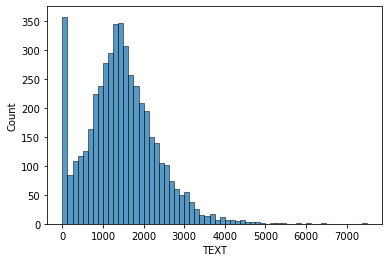

In [ ]:
sns.histplot(data=df_train['TEXT'].str.len())

In [ ]:
all_stopwords = stopwords.words('english')

In [ ]:
df_train['TEXT'] = df_train['TEXT'].apply(lambda x: [item for item in x if item not in all_stopwords])

In [ ]:
df_train['TEXT'] = df_train['TEXT'].apply(lambda x:' '.join(x))

In [ ]:
df_train['TEXT'][1]

'service neurology history present illness summary year old gentleman history cerebral palsy seizure disorder recently moved state admitted hospital one week abdominal pain nausea vomiting found large gallstone fundus gallbladder plan take operating room cholecystectomy laparoscopic cholecystectomy prior surgery loaded gram dilantin started mg mouth every day post surgery noted emergency room witnessed generalized tonic clonic seizure reason loaded consulted neurology team consultation seizure prophylaxis perioperative period recommendation well post surgery scheduled discharged found repeated seizures initially given ativan needed concern status epilepticus transferred hospital ward name intensive care unit monitoring seizures deemed nonepileptic nature subsequently transferred neurology service observed prior discharge past medical history cerebral palsy left right sided hemiparesis seizure disorder allergies allergies multiple antiepileptic medications usually make drowsy physical e

For df_valid:

In [ ]:
df_valid['TEXT'] = df_valid['TEXT'].apply(lambda x:re.sub('[^a-zA-Z]', " ", str(x)).lower())

In [ ]:
# removing repititive words from all observations
# pattern = "admission date|discharge date|date of birth|sex"

df_valid['TEXT'] = df_valid['TEXT'].apply(lambda x:re.sub(pattern," ", str(x)))

In [ ]:
df_valid['TEXT'][0:1]

20564                                                  ...
Name: TEXT, dtype: object

In [ ]:
df_valid['TEXT'] = df_valid['TEXT'].apply(lambda x:x.split())

In [ ]:
df_valid['TEXT'] = df_valid['TEXT'].apply(lambda x: [item for item in x if item not in all_stopwords])

In [ ]:
df_valid['TEXT'] = df_valid['TEXT'].apply(lambda x:' '.join(x))

In [ ]:
df_valid['TEXT'][0:1]

20564    service neurosurgery allergies patient recorde...
Name: TEXT, dtype: object

### Tokenize

In [ ]:
max_leng = 1000
vocabulary_size = 5000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df_train['TEXT'])
sequences = tokenizer.texts_to_sequences(df_train['TEXT'])

In [ ]:
X_train = pad_sequences(sequences, maxlen=max_leng)

In [ ]:
X_train[:5]

array([[   0,    0,    0, ...,  499,  499,  201],
       [   0,    0,    0, ...,  499,  499,  201],
       [   0,    0,    0, ...,  499,  499,  201],
       [  48,   43,   22, ..., 2195,  119,  309],
       [ 117,  198,  519, ...,   72,  201,  309]], dtype=int32)

In [ ]:
sequences_test = tokenizer.texts_to_sequences(df_valid['TEXT'])
X_test = pad_sequences(sequences_test , maxlen=max_leng)

In [ ]:
X_test[:5]

array([[   0,    0,    0, ...,  431,   64,  224],
       [   0,    0,    0, ...,   72,  201,  309],
       [   0,    0,    0, ...,  499,  499,  201],
       [ 154,  280,   66, ...,  224,  210,  119],
       [   0,    0,    0, ..., 1873,  119,  309]], dtype=int32)

In [ ]:
y_train = df_train['OUTPUT_LABEL']
y_test = df_valid['OUTPUT_LABEL']

In [ ]:
print( X_train.shape )
print( X_test.shape )
print( y_train.shape )
print( y_test.shape )

(4784, 1000)
(10223, 1000)
(4784,)
(10223,)


## Model using GloVe Embedding:
When using glove or any other external embedding, do not use stemming or lemmatization.

In [ ]:
# https://nlp.stanford.edu/projects/glove/
embeddings_index = dict()
f = open('/content/drive/My Drive/Colab Notebooks/nlp_scripts/MIMIC-III/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
vocab_size_ext = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size_ext, 100))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
print(vocab_size_ext)
print(vocabulary_size)
print(max_leng)
print(embedding_matrix[1])

41360
5000
1000
[-4.67510015e-01  3.49999994e-01 -4.74500000e-01  9.18579996e-02
 -8.44770014e-01 -3.60950008e-02  5.31849980e-01 -4.82870005e-02
 -1.30820000e+00 -3.28170002e-01  1.61140001e+00  1.35020003e-01
 -6.08749986e-01 -1.11149997e-01  2.19919994e-01  2.39549994e-01
  1.24399997e-01 -5.00800014e-01 -3.24690007e-02  3.26389998e-01
  1.04229999e+00 -1.31449997e-01 -1.05999994e+00  1.03030002e+00
 -1.30050004e-01  5.05990028e-01  7.81400025e-01  3.68579999e-02
 -3.15169990e-01  6.53039992e-01  8.84750009e-01  1.02800000e+00
 -1.02289999e+00 -6.62090003e-01 -6.30680025e-01  7.42810011e-01
  2.75660008e-01  7.34749973e-01 -2.69089997e-01  9.28520024e-01
  1.28149998e+00 -8.82659972e-01  1.72399998e-01 -8.66750002e-01
 -3.85419995e-01  9.19510007e-01 -1.64550006e-01 -1.09940000e-01
 -6.44890010e-01  7.16159999e-01  9.67919976e-02 -2.44870007e-01
 -6.66490018e-01  5.91229975e-01 -4.61739987e-01  4.44349982e-02
 -1.44710004e+00 -7.72219971e-02  3.45609993e-01 -9.55209970e-01
  6.59709

### Deeper CNN model with GloVE:

In [ ]:
filters_num = 2
# vocab_size_ext is from glove
# output_dim=100 is becuase we used the glove embedding file 100d of 100 dimensions

def define_glove_model(max_leng, vocabulary_size):
    inputs = Input(shape=(max_leng,))
    # channel 1
    embedding1 = Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_leng , weights=[embedding_matrix], trainable=False)(inputs)
    conv1 = Conv1D(filters=filters_num, kernel_size = 1, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = GlobalMaxPooling1D()(drop1)
    #flat1 = Flatten()(pool1)
    # channel 2
    embedding2 = Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_leng , weights=[embedding_matrix], trainable=False)(inputs)
    conv2 = Conv1D(filters=filters_num, kernel_size = 2, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = GlobalMaxPooling1D()(drop2)
    #flat2 = Flatten()(pool2)
    # channel 3
    embedding3 = Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_leng , weights=[embedding_matrix], trainable=False)(inputs)
    conv3 = Conv1D(filters=filters_num, kernel_size = 3, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = GlobalMaxPooling1D()(drop3)
    #flat3 = Flatten()(pool3)
    # channel 4
    embedding4 = Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_leng , weights=[embedding_matrix], trainable=False)(inputs)
    conv4 = Conv1D(filters=filters_num, kernel_size = 4, activation='relu')(embedding4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = GlobalMaxPooling1D()(drop4)
    #flat4 = Flatten()(pool4)
    # channel 5
    embedding5 = Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_leng , weights=[embedding_matrix], trainable=False)(inputs)
    conv5 = Conv1D(filters=filters_num, kernel_size = 5, activation='relu')(embedding5)
    drop5 = Dropout(0.5)(conv5)
    pool5 = GlobalMaxPooling1D()(drop5)
    #flat5 = Flatten()(pool5)
    
    # merge
    merged = concatenate([pool1, pool2, pool3, pool4, pool5])
    #dense1 = Dense(hidden_dims, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[inputs], outputs=outputs)
    # compile
    adam = Adam(0.0001)

    model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=[AUC()])
    # summarize
    print(model.summary())
    #plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
model = define_glove_model(max_leng, vocab_size_ext)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1000, 100)    4136000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1000, 100)    4136000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1000, 100)    4136000     input_3[0][0]                    
_______________________________________________________________________________________

In [ ]:
earlystopping_callback = EarlyStopping( monitor="val_loss", min_delta=0.0005, patience=5, restore_best_weights=True)
#lr_callback = ReduceLROnPlateau( monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="auto", min_delta=0.0001, min_lr=0)

keras_callbacks = [earlystopping_callback]

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=2, callbacks=keras_callbacks)

Epoch 1/100
150/150 - 6s - loss: 0.8158 - auc_2: 0.5436 - val_loss: 0.6943 - val_auc_2: 0.5936
Epoch 2/100
150/150 - 6s - loss: 0.7024 - auc_2: 0.5983 - val_loss: 0.6669 - val_auc_2: 0.6179
Epoch 3/100
150/150 - 6s - loss: 0.6769 - auc_2: 0.6352 - val_loss: 0.6567 - val_auc_2: 0.6289
Epoch 4/100
150/150 - 6s - loss: 0.6736 - auc_2: 0.6420 - val_loss: 0.7185 - val_auc_2: 0.6400
Epoch 5/100
150/150 - 6s - loss: 0.6637 - auc_2: 0.6546 - val_loss: 0.6938 - val_auc_2: 0.6411
Epoch 6/100
150/150 - 6s - loss: 0.6532 - auc_2: 0.6674 - val_loss: 0.6657 - val_auc_2: 0.6405
Epoch 7/100
150/150 - 6s - loss: 0.6427 - auc_2: 0.6832 - val_loss: 0.6384 - val_auc_2: 0.6399
Epoch 8/100
150/150 - 6s - loss: 0.6469 - auc_2: 0.6776 - val_loss: 0.6411 - val_auc_2: 0.6460
Epoch 9/100
150/150 - 6s - loss: 0.6359 - auc_2: 0.6930 - val_loss: 0.6554 - val_auc_2: 0.6479
Epoch 10/100
150/150 - 6s - loss: 0.6302 - auc_2: 0.7016 - val_loss: 0.7917 - val_auc_2: 0.6586
Epoch 11/100
150/150 - 6s - loss: 0.6294 - auc_2:

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'auc_2', 'val_loss', 'val_auc_2'])


In [ ]:
glove_model_auc = history.history['val_auc_2'][-1]
glove_model_auc 

0.6474608778953552

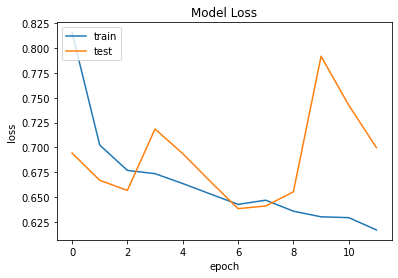

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

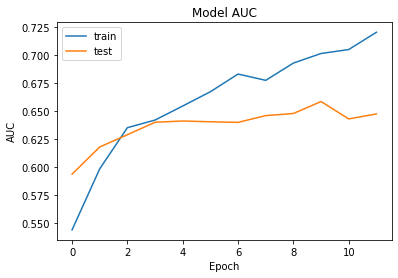

In [ ]:
# model auc plot
plt.plot(history.history['auc_2'])
plt.plot(history.history['val_auc_2'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model using keras embedding:

### Deeper CNN model with keras embedding:

In [ ]:
filters_num = 2
# input_dim=vocabulary_size : choosen above by looking at the average len of words in our text
# output_dim=32 : you can choose your own #
def define_keras_model(max_leng, vocabulary_size):
    inputs = Input(shape=(max_leng,))
    # channel 1
    embedding1 = Embedding(input_dim=vocabulary_size,output_dim=32, input_length=max_leng)(inputs)
    conv1 = Conv1D(filters=filters_num, kernel_size = 1, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = GlobalMaxPooling1D()(drop1)
    #flat1 = Flatten()(pool1)
    # channel 2
    embedding2 = Embedding(input_dim=vocabulary_size,output_dim=32, input_length=max_leng)(inputs)
    conv2 = Conv1D(filters=filters_num, kernel_size = 2, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = GlobalMaxPooling1D()(drop2)
    #flat2 = Flatten()(pool2)
    # channel 3
    embedding3 = Embedding(input_dim=vocabulary_size,output_dim=32, input_length=max_leng)(inputs)
    conv3 = Conv1D(filters=filters_num, kernel_size = 3, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = GlobalMaxPooling1D()(drop3)
    #flat3 = Flatten()(pool3)
    # channel 3
    embedding4 = Embedding(input_dim=vocabulary_size,output_dim=32, input_length=max_leng)(inputs)
    conv4 = Conv1D(filters=filters_num, kernel_size = 4, activation='relu')(embedding4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = GlobalMaxPooling1D()(drop4)
    #flat4 = Flatten()(pool4)
    # channel 3
    embedding5 = Embedding(input_dim=vocabulary_size,output_dim=32, input_length=max_leng)(inputs)
    conv5 = Conv1D(filters=filters_num, kernel_size = 5, activation='relu')(embedding5)
    drop5 = Dropout(0.5)(conv5)
    pool5 = GlobalMaxPooling1D()(drop5)
    #flat5 = Flatten()(pool5)
    # merge
    merged = concatenate([pool1, pool2, pool3, pool4, pool5])
    #merged = concatenate([flat1, flat2, flat3, flat4, flat5])
    #dense1 = Dense(hidden_dims, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(merged)
    model = Model(inputs=[inputs], outputs=outputs)
    # compile
    adam = Adam(0.0001)

    model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=[AUC()])
    # summarize
    print(model.summary())

    return model

In [ ]:
model = define_keras_model(max_leng, vocabulary_size)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1000, 32)     160000      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1000, 32)     160000      input_5[0][0]                    
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1000, 32)     160000      input_5[0][0]                    
_______________________________________________________________________________________

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, callbacks = keras_callbacks, verbose=2)

Epoch 1/200
150/150 - 6s - loss: 0.6752 - auc_4: 0.6144 - val_loss: 0.6948 - val_auc_4: 0.6738
Epoch 2/200
150/150 - 6s - loss: 0.6334 - auc_4: 0.7040 - val_loss: 0.6428 - val_auc_4: 0.6923
Epoch 3/200
150/150 - 6s - loss: 0.6047 - auc_4: 0.7397 - val_loss: 0.6696 - val_auc_4: 0.6957
Epoch 4/200
150/150 - 5s - loss: 0.5769 - auc_4: 0.7726 - val_loss: 0.6233 - val_auc_4: 0.6990
Epoch 5/200
150/150 - 6s - loss: 0.5354 - auc_4: 0.8177 - val_loss: 0.6431 - val_auc_4: 0.6948
Epoch 6/200
150/150 - 6s - loss: 0.4932 - auc_4: 0.8542 - val_loss: 0.6142 - val_auc_4: 0.6967
Epoch 7/200
150/150 - 6s - loss: 0.4420 - auc_4: 0.8953 - val_loss: 0.6038 - val_auc_4: 0.6900
Epoch 8/200
150/150 - 6s - loss: 0.4058 - auc_4: 0.9104 - val_loss: 0.6403 - val_auc_4: 0.6866
Epoch 9/200
150/150 - 6s - loss: 0.3565 - auc_4: 0.9351 - val_loss: 0.6496 - val_auc_4: 0.6836
Epoch 10/200
150/150 - 6s - loss: 0.3108 - auc_4: 0.9539 - val_loss: 0.6483 - val_auc_4: 0.6796
Epoch 11/200
150/150 - 6s - loss: 0.2736 - auc_4:

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'auc_4', 'val_loss', 'val_auc_4'])


In [ ]:
keras_model_auc = history.history['val_auc_4'][-1]
keras_model_auc 

0.6735864877700806

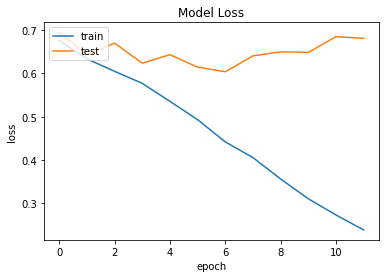

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

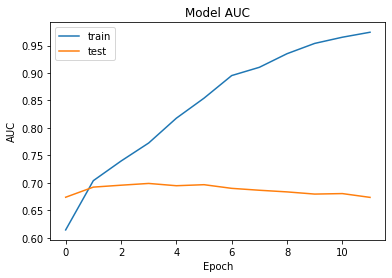

In [ ]:
# model auc plot
plt.plot(history.history['auc_4'])
plt.plot(history.history['val_auc_4'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model using distilBERT

Converting text and target variable into str type to send as input for BERT

In [ ]:
df_train['TEXT'] = df_train['TEXT'].astype('str')
df_train['OUTPUT_LABEL'] = df_train['OUTPUT_LABEL'].astype('str')

In [ ]:
df_valid['TEXT'] = df_valid['TEXT'].astype('str')
df_valid['OUTPUT_LABEL'] = df_valid['OUTPUT_LABEL'].astype('str')

In [ ]:
# max_len for distillbert = 512
(train, val, preproc) = text.texts_from_df(train_df=df_train, text_column='TEXT', label_columns='OUTPUT_LABEL', val_df = df_valid, maxlen = 512, preprocess_mode = 'distilbert')


preprocessing train...
language: en
train sequence lengths:
	mean : 1011
	95percentile : 2044
	99percentile : 2702


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 926
	95percentile : 1918
	99percentile : 2549


In [ ]:
model = text.text_classifier(name = 'distilbert', train_data = train, preproc=preproc)

Is Multi-Label? False
maxlen is 512



done.


In [ ]:
learner = ktrain.get_learner(model = model, train_data = train, val_data = val, batch_size = 6)

In [ ]:
learner.fit_onecycle(lr = 2e-5, epochs=5)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
798/798 [==============================] - 559s 700ms/step - loss: 0.6933 - accuracy: 0.5111 - val_loss: 0.7152 - val_accuracy: 0.1596
Epoch 2/5
798/798 [==============================] - 558s 699ms/step - loss: 0.6789 - accuracy: 0.5761 - val_loss: 0.6204 - val_accuracy: 0.7248
Epoch 3/5
798/798 [==============================] - 557s 698ms/step - loss: 0.6550 - accuracy: 0.6179 - val_loss: 0.7090 - val_accuracy: 0.5835
Epoch 4/5
798/798 [==============================] - 556s 697ms/step - loss: 0.6243 - accuracy: 0.6664 - val_loss: 0.6378 - val_accuracy: 0.6394
Epoch 5/5
798/798 [==============================] - 557s 698ms/step - loss: 0.5525 - accuracy: 0.7312 - val_loss: 0.7370 - val_accuracy: 0.5836


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
predictor.get_classes()

['0', '1']

In [ ]:
df_valid['TEXT'][0:1].values

array(['service neurosurgery allergies patient recorded known allergies drugs attending first name lf chief complaint fall major surgical invasive procedure none history present illness year old female presented osh today reportedly falling reaching shampoo bottle bathroom patient cannot recall falling feeling dizzy remember trying reach shampoo bottle head ct osh shows right parietal sdh mm x cm small contusion small sah several skull fractures reportedly orthostatic hypotension osh found uti abx started patient sent hospital evaluation patient dizziness headache visual changes pain anywhere chest pain sob ros negative past medical history hypertension hypothyroidism glaucoma djd social history lives home alone dog family history non contributory physical exam bp hr rr sats gen lying stretcher cervical collar place heent pupils perrl eoms intact mild ptosis right upper eyelid neck cervical collar point tenderness lungs cta bilaterally cardiac rrr abd soft nt bs extrem warm well perfus

In [ ]:
# y_pred
y_pred =  predictor.predict(df_valid['TEXT'][0:].values, return_proba=True)
y_pred

array([[0.31881076, 0.6811892 ],
       [0.66848516, 0.33151478],
       [0.6065253 , 0.3934747 ],
       ...,
       [0.50629574, 0.49370426],
       [0.48692283, 0.51307714],
       [0.62594277, 0.37405726]], dtype=float32)

In [ ]:
df_valid['OUTPUT_LABEL'] = df_valid['OUTPUT_LABEL'].astype('int')

In [ ]:
fpr, tpr, thresholds = roc_curve( df_valid['OUTPUT_LABEL'], y_pred[:,1] )

In [ ]:
bert_model_auc = auc(fpr, tpr)
bert_model_auc

0.6118200618436256

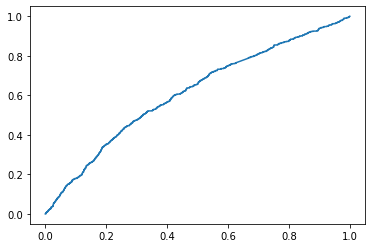

In [ ]:
plt.plot(fpr, tpr)

## Conclusion:

In [ ]:
results = pd.DataFrame([glove_model_auc, keras_model_auc, bert_model_auc], index=['Glove embedding model', 'Keras embedding model', 'BERT model'], columns=['Test_AUC'])
results

,Test_AUC
Glove embedding model,0.647461
Keras embedding model,0.673586
BERT model,0.611820


The model with external embedding(GloVe) and model without external embedding(keras embedding) both are overfitting the training data. Also the validation loss is fluctuating and not very stable. Earlystopping was used for both the models to get better results. 
Tried to stabilize the validation loss by trying to reduce the number of filters and by reducing the complexity of the model. The AUC for both the models are displayed in the table above, but to create better models there might be need of more samples for training data.

Among all three models, the best performing model with highest to lowest AUC are:
1.   Model using Keras embedding layer
2.   Model using GloVe embedding layer
3.   BERT model


